# <center>                                        Speech Emotion Recognition

### <center>                                    What is Speech Emotion Recognition?

#### Definition : 

Speech emotion recognition (SER) is the field of technology focused on identifying the emotional state of a speaker from their voice.  This goes beyond the words spoken and analyzes how they are spoken.

#### How it Works :

* **Speech Input**: Similar to standard speech recognition, the user's voice is recorded.
* **Pre-processing**: The audio is prepared by removing noise and potentially isolating specific speech segments.
* **Feature Extraction**: Crucial features related to emotions are extracted. These include:
* **Prosodic features**: Pitch, intonation, volume, speaking rate, pauses
* **Spectral Features**: Spectrum of the voice, MFCCs (emphasizing qualities similar to human perception)
* **Voice Quality Features**: Jitter, shimmer (small variations in voice quality)
* **Emotion Model**: A trained machine learning model (often using classification algorithms) takes these features and identifies the associated emotion.
* **Emotion Output**: The system outputs the detected emotion, typically with probability or confidence scores (e.g., angry, happy, sad, neutral, etc.).

#### Applications of Speech Emotion Recognition :

* **Mental Health**: Potential uses in diagnosing and monitoring mental health conditions, detecting stress or depression.
* **Customer Service**: Analyzing customer interactions in call centers to improve service and gauge satisfaction.
* **Human-Computer Interaction**: Creating more responsive and emotionally intelligent virtual assistants and robots.
* **Market Research**: Analyzing focus group responses or advertisement reception to understand emotional reactions.
* **Game Design**: Developing adaptive games that change based on a player's emotional state.

### 1. Set up dependencies:

In [125]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import os
import pandas as pd
import IPython.display as ipd
import plotly.express as px
import sys
from tensorflow.python.client import device_lib
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, Shift, TimeMask, SpecFrequencyMask
from joblib import Parallel, delayed
import timeit
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [126]:
# Checking whether GPUs are available to use or not
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3353037424432087348
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2243113780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14796393108881754263
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


### 2. Data Processing

#### 2.1 Ravdess Data Set

In [127]:
# Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess) 
# (https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio)
# Extract to the folder ./rav

RAV = './rav/audio_speech_actors_01-24/'
dir_list = os.listdir(RAV)

emotion = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        # Extract emotion label
        emotion.append(int(part[2]))

        # Extract path
        path.append(RAV + i + '/' + f)
        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df.columns = ['Emotions']
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['Path'])],axis=1)
RAV_df.Emotions.value_counts()




neutral     288
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
Name: Emotions, dtype: int64

#### 2.2 Crema Data Set

In [128]:
# Crowd Sourced Emotional Multimodal Actors Dataset (CREMA-D)
# (https://www.kaggle.com/datasets/ejlok1/cremad)
# Extract to the folder ./cremad

# CREMA = "./cremad/AudioWAV/"
# crema_directory_list = os.listdir(CREMA)

# file_emotion = []
# file_path = []

# for file in crema_directory_list:
#     # storing file paths
#     file_path.append(CREMA + file)
#     # storing file emotions
#     part=file.split('_')
#     if part[2] == 'SAD':
#         file_emotion.append('sad')
#     elif part[2] == 'ANG':
#         file_emotion.append('angry')
#     elif part[2] == 'DIS':
#         file_emotion.append('disgust')
#     elif part[2] == 'FEA':
#         file_emotion.append('fear')
#     elif part[2] == 'HAP':
#         file_emotion.append('happy')
#     elif part[2] == 'NEU':
#         file_emotion.append('neutral')
#     else:
#         file_emotion.append('Unknown')
        
# # dataframe for emotion of files
# emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# # dataframe for path of files.
# path_df = pd.DataFrame(file_path, columns=['Path'])
# Crema_df = pd.concat([emotion_df, path_df], axis=1)
# Crema_df.head()
# print(Crema_df.Emotions.value_counts())






#### 2.3 Tess Data Set

In [129]:
# Toronto emotional speech set (TESS)
# (https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess)
# Extract to the folder /tess

TESS = "./tess/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/"
tess_directory_list = os.listdir(TESS)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(TESS + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(TESS + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: Emotions, dtype: int64


#### 2.4 Savee Data Set

In [130]:
# Surrey Audio-Visual Expressed Emotion (SAVEE)
# (https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee)
# Extract to the folder ./savee

# SAVEE = "./savee/ALL/"
# savee_directory_list = os.listdir(SAVEE)

# file_emotion = []
# file_path = []

# for file in savee_directory_list:
#     file_path.append(SAVEE + file)
#     part = file.split('_')[1]
#     ele = part[:-6]
#     if ele=='a':
#         file_emotion.append('angry')
#     elif ele=='d':
#         file_emotion.append('disgust')
#     elif ele=='f':
#         file_emotion.append('fear')
#     elif ele=='h':
#         file_emotion.append('happy')
#     elif ele=='n':
#         file_emotion.append('neutral')
#     elif ele=='sa':
#         file_emotion.append('sad')
#     else:
#         file_emotion.append('surprise')
        
# # dataframe for emotion of files
# emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# # dataframe for path of files.
# path_df = pd.DataFrame(file_path, columns=['Path'])
# Savee_df = pd.concat([emotion_df, path_df], axis=1)
# Savee_df.head()
# print(Savee_df.Emotions.value_counts())


In [131]:
main_df = pd.concat([ RAV_df, Tess_df], axis=0)
main_df.to_csv("data_path.csv",index=False)
main_df.head()
print(main_df.Emotions.value_counts())


neutral     688
happy       592
sad         592
angry       592
fear        592
disgust     592
surprise    592
Name: Emotions, dtype: int64


### 3. Data Visualization :

In [132]:
def visualize_emotions(df, title):
    px_fig = px.histogram(df,
                          x="Emotions",
                          color='Emotions',
                          title=title)
    px_fig.show()

#### 3.1 Ravdess Data Set

In [166]:
visualize_emotions(RAV_df, "Emotion Visualization Of Rav Data Set")

#### 3.2 Crema Data Set

In [ ]:
visualize_emotions(RAV_df, "Emotion Visualization Of Crema Data Set")

#### 3.3 Tess Data Set

In [135]:
visualize_emotions(Tess_df, "Emotion Visualization Of Tess Data Set")

#### 3.4 Savee Data Set

In [136]:
# visualize_emotions(Savee_df, "Emotion Visualization Of Savee Data Set")

#### 3.5 Combined Data Set

In [137]:
px_fig = px.histogram(main_df,
                      x='Emotions',
                      color='Emotions',
                      title='Emotion Count')
px_fig.update_layout(bargap=0.2)
px_fig.show()

In [138]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb,
                             sr=sr,
                             x_axis='time',
                             y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.show()

def plot_magnitude_spectrum(signal, sr, ratio, e):
    fft = np.abs(np.fft.fft(signal)) 
    frequency = np.linspace(0, sr, len(fft))
    range = int(len(frequency) * ratio) 
    plt.plot(frequency[:range], fft[:range])
    plt.xlabel("Frequency")
    plt.title("Magnitude Spectrum for audio with {} emption".format(e))
    plt.show()

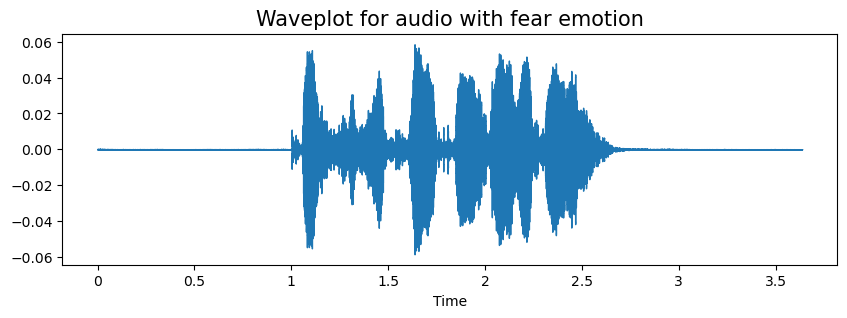

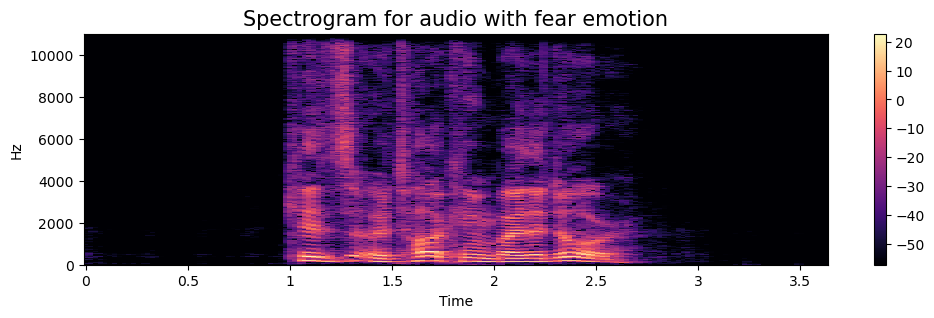

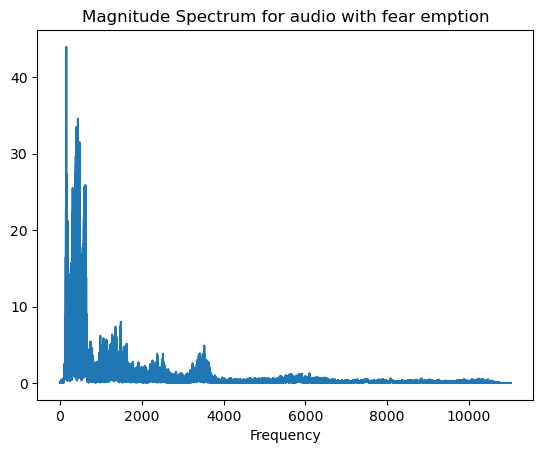

In [168]:
emotion='fear'
path = np.array(RAV_df.Path[RAV_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
plot_magnitude_spectrum(data, sampling_rate, 0.5, emotion)
ipd.Audio(path)

### 4. Data Augmentation :

In [140]:
# Manual
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

noise_aug = AddGaussianNoise(min_amplitude=0.0001,
                             max_amplitude=0.0005,
                             p=1)

pitch_aug = PitchShift(min_semitones=-7.0,
                       max_semitones=7.0,
                       p=1)

time_stretch_aug = TimeStretch(min_rate=0.8,
                               max_rate=1.25,
                               leave_length_unchanged=True,
                               p=1)

shift_aug = Shift(min_fraction=-0.1,
                  max_fraction=0.1,
                  rollover=True,
                  p=1)



time_mask = TimeMask(min_band_part=0.1,
    max_band_part=0.15,
    fade=True,
    p=1.0,
)

aug = Compose([PitchShift(min_semitones=-7.0,
                          max_semitones=7.0,
                          p=0.5),
               TimeStretch(min_rate=0.8,
                          max_rate=1.25,
                          leave_length_unchanged=True,
                          p=0.5),
               TimeMask(min_band_part=0.1,
                        max_band_part=0.15,
                        fade=True,
                        p=0.5)
                ])
 

#### 4.1 Simple Audio:

In [141]:
# Load an exampl file
path = np.array(RAV_df.Path)[1]
data, sample_rate = librosa.load(path)

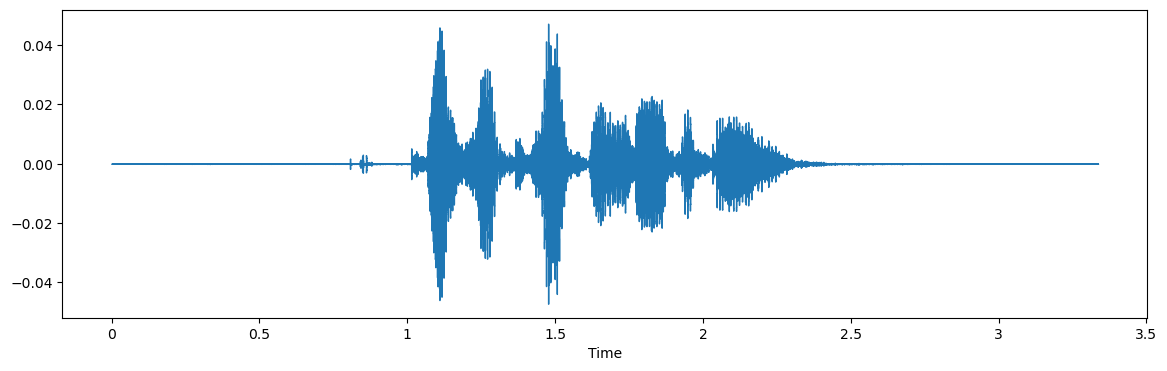

In [142]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
ipd.Audio(path)

#### 4.2 Noise Injection :

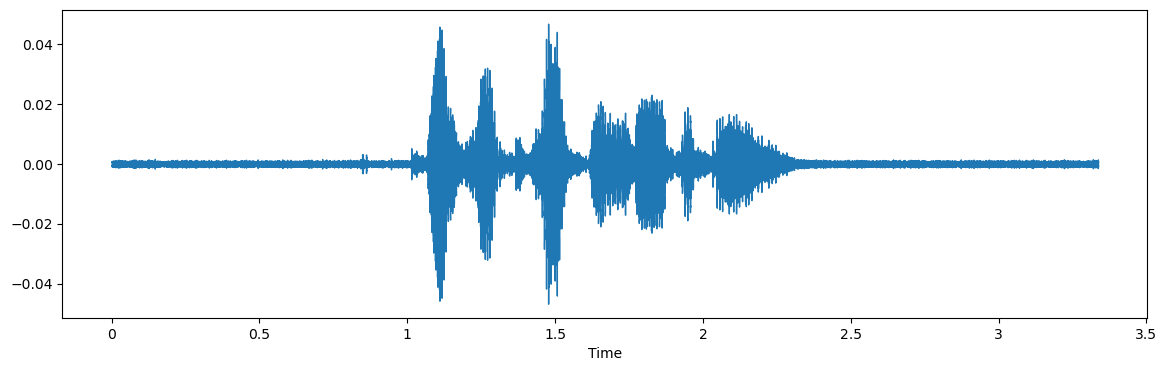

In [143]:
x = noise_aug(samples=data, sample_rate=sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

#### 4.3 Pitching :

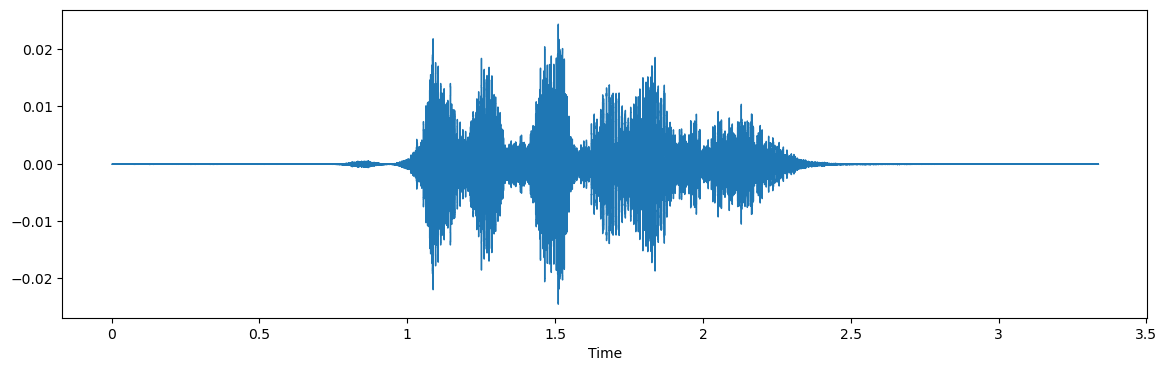

In [144]:
x = pitch_aug(samples=data, sample_rate=sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

#### 4.4 Streching :

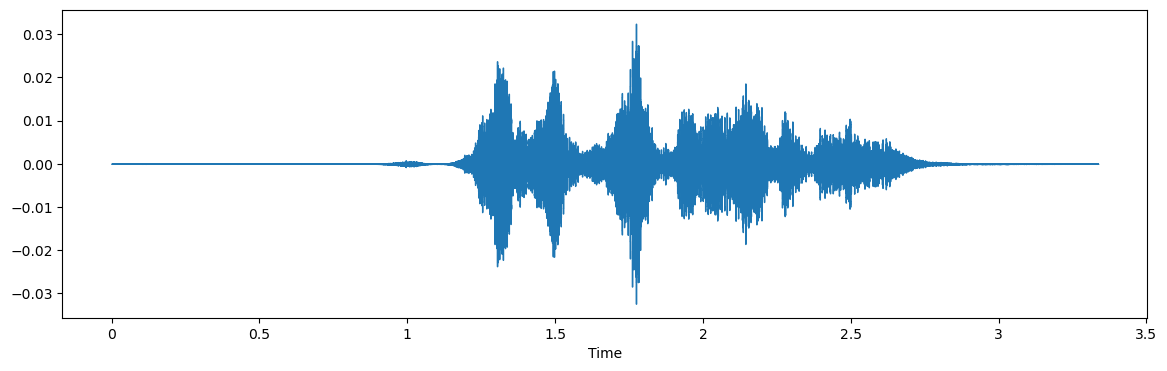

In [145]:
x = time_stretch_aug(samples=data, sample_rate=sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

#### 4.4 Shifting :

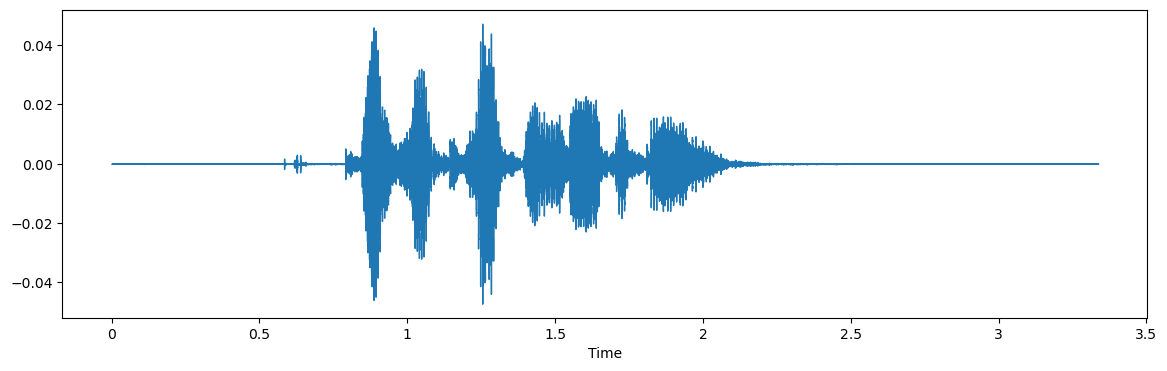

In [146]:
x = shift_aug(samples=data, sample_rate=sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

#### 4.5 Combining :

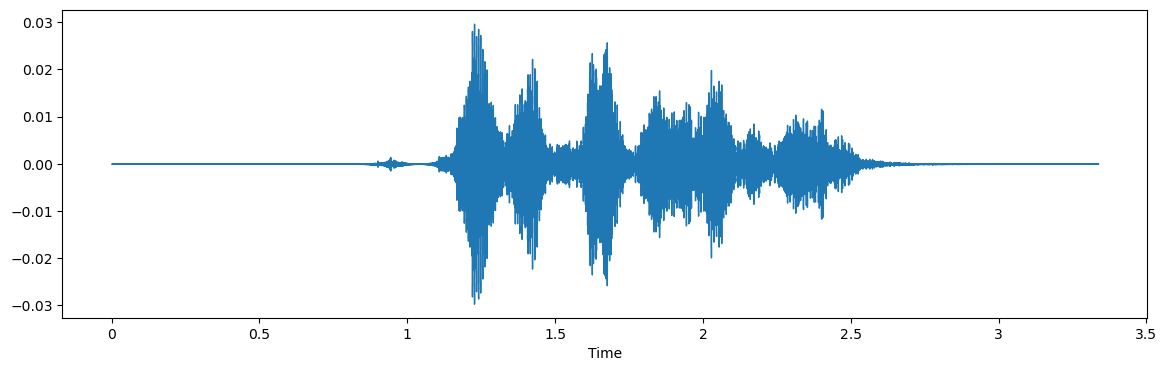

In [147]:
x = aug(samples=data, sample_rate=sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

### 5 Feature Extraction :

In [148]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def stack_augmented_layers(result, data, sample_rate, times):
    for _ in range(times):
        aug_data = aug(samples=data, sample_rate=sample_rate)  
        res = extract_features(aug_data)  
        result = np.vstack((result, res))   # stacking vertically
    
    return result


def get_features(path, is_aug):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    res1 = extract_features(data)
    result = np.array(res1)
    
    if (is_aug):
        # Augementing data seperately
        # time_mask_data = time_mask(sample_rate=sample_rate, samples=data)
        # time_mask_data_feature = extract_features(time_mask_data)

        # time_strech_data = time_stretch_aug(sample_rate=sample_rate, samples=data)
        # time_stretch_data_feature = extract_features(time_strech_data)

        # piched_data = pitch_aug(sample_rate=sample_rate, samples=data)
        # pitched_data_feature = extract_features(piched_data)\
        
        # result = np.vstack((result, time_mask_data_feature))
        # result = np.vstack((result, time_stretch_data_feature))
        # result = np.vstack((result, pitched_data_feature))

        # Augment data composedly
        # noise_data = noise(data)
        # res2 = extract_features(noise_data)
        # result = np.vstack((result, res2)) # stacking vertically

        result = stack_augmented_layers(result=result,
                                        data=data,
                                        sample_rate=sample_rate,
                                        times=2)
        
    return result



### 6. Data Preperation :

#### 6.1 Splitting data

In [149]:
# Step 1: Split the data into train (70%) and temp (30%) using stratification on the 'Emotions' column
train_df, temp_df = train_test_split(
    main_df,
    test_size=0.3,
    stratify=main_df['Emotions'],  # Use the existing 'Emotions' column for stratification
    random_state=42
)

# Step 2: Split the temp data into validation (20%) and test (10%) using stratification on the 'Emotions' column
val_df, test_df = train_test_split(
    temp_df,
    test_size=1/3,  # 1/3 of 30% = 10%
    stratify=temp_df['Emotions'],  # Use the 'Emotions' column for stratification
    random_state=42
)


# Step 3: Print the sizes of each split
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

# Step 4: Check the distribution of labels in each split (optional)
print("Train distribution:\n", train_df['Emotions'].value_counts())
print("Validation distribution:\n", val_df['Emotions'].value_counts())
print("Test distribution:\n", test_df['Emotions'].value_counts())



Train size: 2968
Validation size: 848
Test size: 424
Train distribution:
 neutral     482
disgust     415
angry       415
sad         414
surprise    414
happy       414
fear        414
Name: Emotions, dtype: int64
Validation distribution:
 neutral     137
happy       119
fear        119
surprise    119
angry       118
disgust     118
sad         118
Name: Emotions, dtype: int64
Test distribution:
 neutral     69
sad         60
happy       59
angry       59
disgust     59
surprise    59
fear        59
Name: Emotions, dtype: int64


#### 6.2 Saving feature data

In [150]:
# def extract_feature(df, is_aug):
#     X, Y = [], []
#     start = timeit.default_timer()
#     for path, emotion in zip(df.Path, df.Emotions):
#         feature = get_features(path, is_aug=is_aug)
#         if (is_aug):
#             for ele in feature:
#                 X.append(ele)
#                 Y.append(emotion)
#         else:
#             X.append(feature)
#             Y.append(emotion)

#     stop = timeit.default_timer()
#     print('Normal way to get feature: ', stop - start)

#     return X, Y

In [151]:
def process_feature(path, emotion, is_aug):
    features = get_features(path, is_aug)
    X = []
    Y = []
    if (is_aug):
        for ele in features:
            X.append(ele)
            Y.append(emotion)
    else:
        X.append(features)
        Y.append(emotion)
    return X, Y

def extract_feature(df, is_aug):
    start = timeit.default_timer()

    paths = df.Path
    emotions = df.Emotions
    
    results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion, is_aug) for (path, emotion) in zip(paths, emotions))

    X = []
    Y = []

    for result in results:
        x, y = result
        X.extend(x)
        Y.extend(y)

    stop = timeit.default_timer()

    print('Get feature for training set in parallel manner: ', stop - start)

    return X, Y


# Only apply data augumentation for training set
X, Y = extract_feature(train_df, is_aug=True)  
X_val, Y_val = extract_feature(val_df, is_aug=False)
X_test, Y_test = extract_feature(test_df, is_aug=False)

Get feature for training set in parallel manner:  66.6092971999999
Get feature for training set in parallel manner:  5.028604300000097
Get feature for training set in parallel manner:  2.2993306999999277


In [152]:
len(X), len(Y), len(X_val), len(Y_val), len(X_test), len(Y_test)

(8904, 8904, 848, 848, 424, 424)

In [153]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

Features_val = pd.DataFrame(X_val)
Features_val['labels'] = Y_val
Features_val.to_csv('features_val.csv', index=False)

Features_test = pd.DataFrame(X_test)
Features_test['labels'] = Y_test
Features_test.to_csv('features_test.csv', index=False)

#### 6.3 Normalizing data

In [154]:
# Cleansing data
Features=Features.fillna(0)
Features_val=Features_val.fillna(0)
Features_test=Features_test.fillna(0)


In [155]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

X_val = Features_val.iloc[: ,:-1].values
Y_val = Features_val['labels'].values

X_test = Features_test.iloc[: ,:-1].values
Y_test = Features_test['labels'].values



In [156]:
# Normalizing label
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
Y_val = encoder.fit_transform(np.array(Y_val).reshape(-1,1)).toarray()
Y_test = encoder.fit_transform(np.array(Y_test).reshape(-1,1)).toarray()

In [157]:
# Normalizing data
scaler = StandardScaler()

X = scaler.fit_transform(X)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

In [158]:
# Add a dimension (depth = 1, voice channel)
X = np.expand_dims(X, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X.shape, Y.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((8904, 162, 1), (8904, 7), (848, 162, 1), (848, 7), (424, 162, 1), (424, 7))

### 7. Modeling & Training

In [159]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 81, 256)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 81, 128)           163968    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 41, 128)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 41, 64)            41024     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 21, 64)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 21, 64)           

In [160]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.0000001)
history=model.fit(X, Y, batch_size=64, epochs=50, validation_data=(X_val, Y_val), callbacks=[rlrp])



Epoch 1/50
140/140 [==============================] - 2s 11ms/step - loss: 1.7588 - accuracy: 0.2853 - val_loss: 1.3954 - val_accuracy: 0.4870
Epoch 2/50
140/140 [==============================] - 1s 10ms/step - loss: 1.4353 - accuracy: 0.4290 - val_loss: 1.1204 - val_accuracy: 0.6014
Epoch 3/50
140/140 [==============================] - 1s 9ms/step - loss: 1.2689 - accuracy: 0.5103 - val_loss: 1.0011 - val_accuracy: 0.6616
Epoch 4/50
140/140 [==============================] - 1s 9ms/step - loss: 1.1650 - accuracy: 0.5563 - val_loss: 0.9135 - val_accuracy: 0.7028
Epoch 5/50
140/140 [==============================] - 1s 10ms/step - loss: 1.0733 - accuracy: 0.5947 - val_loss: 0.8602 - val_accuracy: 0.7040
Epoch 6/50
140/140 [==============================] - 1s 10ms/step - loss: 1.0001 - accuracy: 0.6281 - val_loss: 0.7126 - val_accuracy: 0.7642
Epoch 7/50
140/140 [==============================] - 1s 10ms/step - loss: 0.9279 - accuracy: 0.6571 - val_loss: 0.7603 - val_accuracy: 0.7488
E

### 8. Evaluation

14/14 [==============================] - 0s 5ms/step - loss: 0.7391 - accuracy: 0.7925
Accuracy of our model on test data :  79.24528121948242 %


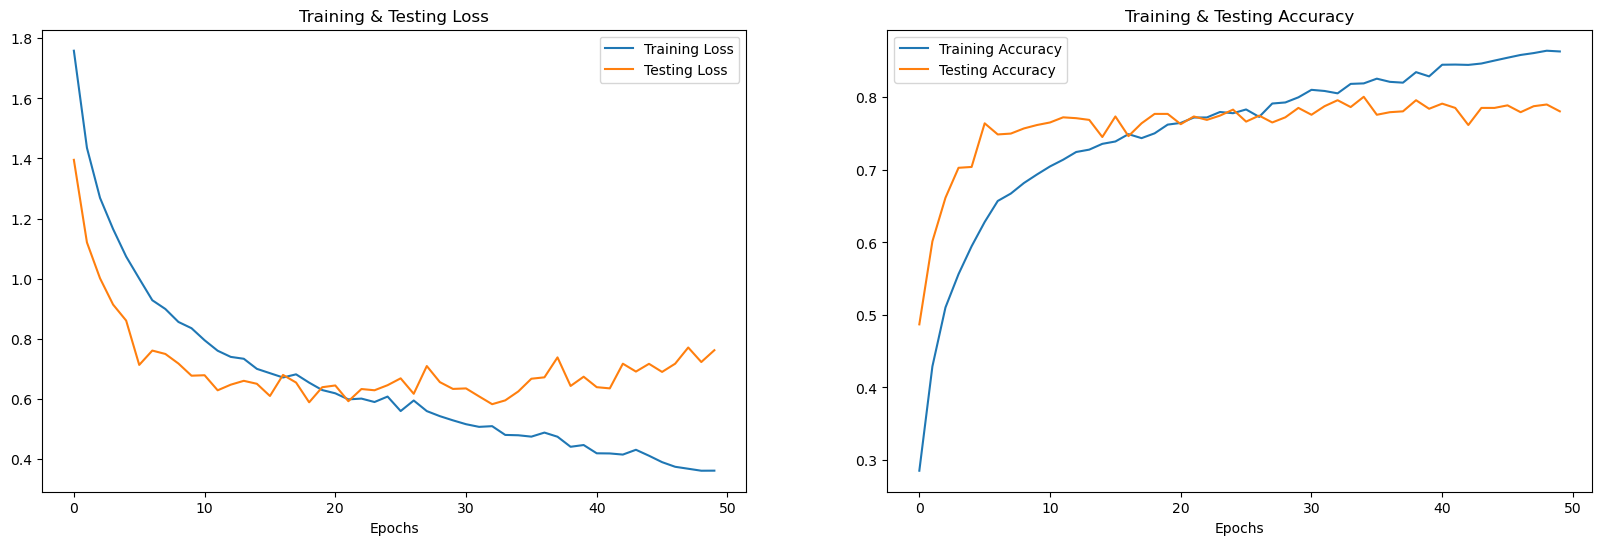

In [161]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()  
ax[1].set_xlabel("Epochs")
plt.show()


In [162]:
pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(Y_test)


In [163]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

display(df.head())

,Predicted Labels,Actual Labels
0,neutral,neutral
1,happy,happy
2,fear,angry
3,sad,sad
4,neutral,neutral


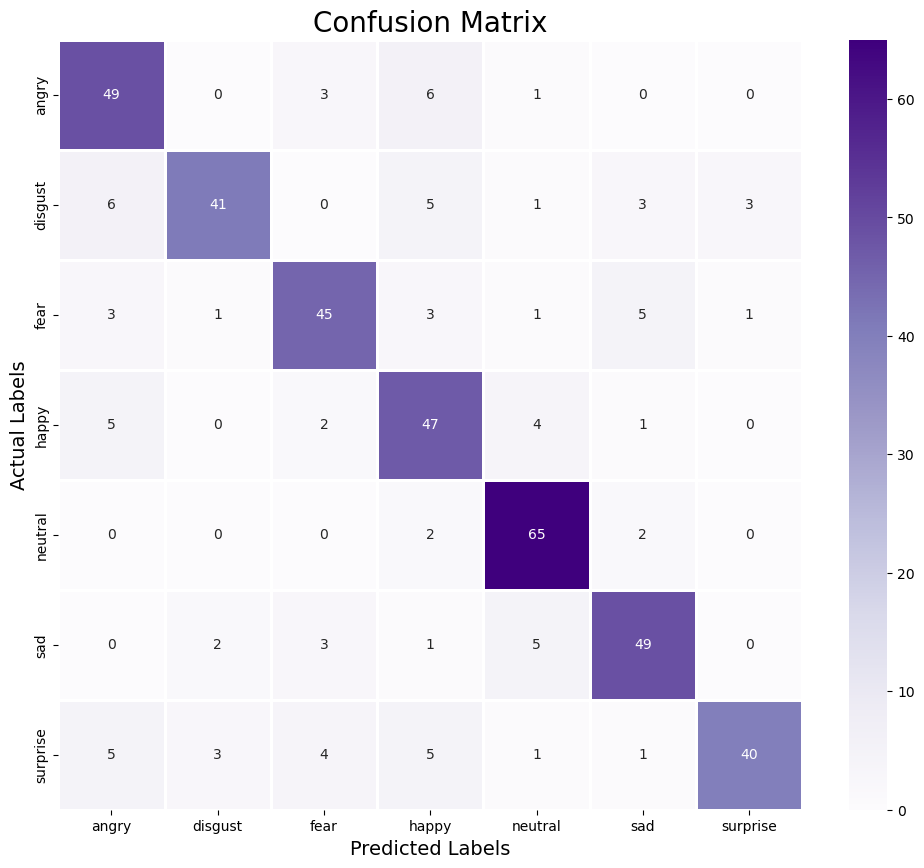

In [164]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [165]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.72      0.83      0.77        59
     disgust       0.87      0.69      0.77        59
        fear       0.79      0.76      0.78        59
       happy       0.68      0.80      0.73        59
     neutral       0.83      0.94      0.88        69
         sad       0.80      0.82      0.81        60
    surprise       0.91      0.68      0.78        59

    accuracy                           0.79       424
   macro avg       0.80      0.79      0.79       424
weighted avg       0.80      0.79      0.79       424

